In [61]:
#Initializations

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("../../train.csv")
X = df["Text"].values
y = df["Category"].values
m = 0.9 #proportion of data for training vs validation
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=m, random_state=42, shuffle=True)

### Task 2a

(a) NB. Train a Naive Bayes classifier using all articles features. Report the (i) top-20 most identifiable words that are most likely to occur in the articles over two classes using your NB classifier, and (ii) the top-20 words that maximize the following quantity:
𝑷𝑷(𝑿𝑿𝒘𝒘 = 𝟏𝟏|𝒀𝒀 = 𝒚𝒚)/𝑷𝑷(𝑿𝑿𝒘𝒘 = 𝟏𝟏|𝒀𝒀 ≠ 𝒚𝒚).

Which list of words describe the two classes better? Briefly explain your reasoning.

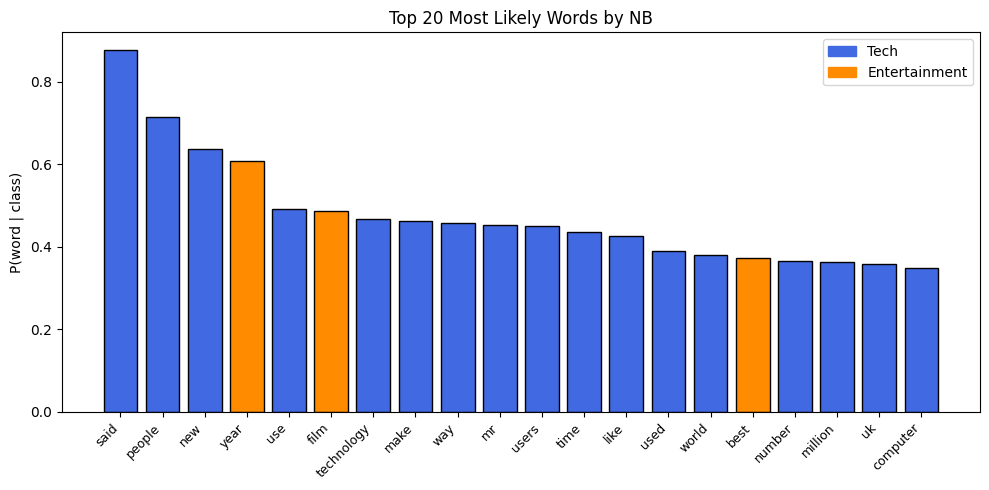

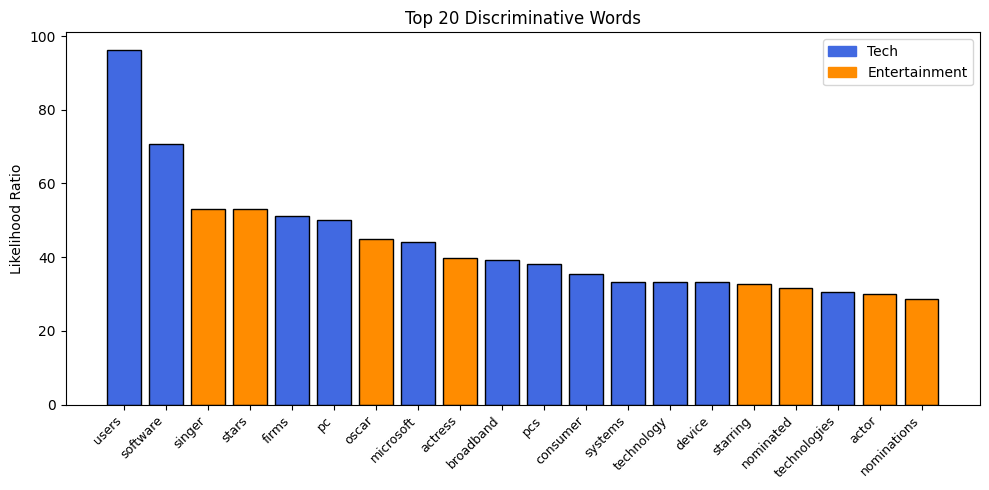

In [62]:
# Vectorize data
vectorizer = CountVectorizer(binary=True, stop_words='english')
X_bin = vectorizer.fit_transform(X)
vocab = np.array(vectorizer.get_feature_names_out())

def get_word_stats(class_label):
    #Compute P(w|class), P(w|not class), and likelihood ratio
    X_class = X_bin[y == class_label]
    X_not_class = X_bin[y != class_label]

    Pw_class = (X_class.sum(axis=0) + 1) / (X_class.shape[0] + 2)
    Pw_not_class = (X_not_class.sum(axis=0) + 1) / (X_not_class.shape[0] + 2)
    ratio = (Pw_class / Pw_not_class).A1
    probs = Pw_class.A1

    return probs, ratio

# Compute stats for both classes
probs_tech, ratios_tech = get_word_stats("tech")
probs_ent, ratios_ent = get_word_stats("entertainment")

def combine_and_rank(metric_tech, metric_ent):
    #Combine both class metrics and select top K words
    top_tech = np.argsort(metric_tech)[-20:]
    top_ent = np.argsort(metric_ent)[-20:]
    combined = np.unique(np.concatenate((top_tech, top_ent)))

    vals, classes = [], []
    for i in combined:
        if metric_tech[i] > metric_ent[i]:
            vals.append(metric_tech[i])
            classes.append("tech")
        else:
            vals.append(metric_ent[i])
            classes.append("entertainment")

    sorted_idx = np.argsort(vals)[-20:][::-1]
    return vocab[combined][sorted_idx], np.array(vals)[sorted_idx], np.array(classes)[sorted_idx]

def plot_bar(words, values, classes, ylabel, title):
    """Plot the bar chart."""
    colors = ['royalblue' if c == "tech" else 'darkorange' for c in classes]
    plt.figure(figsize=(10, 5))
    plt.bar(words, values, color=colors, edgecolor='black')
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(handles=[
        plt.Rectangle((0, 0), 1, 1, color='royalblue', label='Tech'),
        plt.Rectangle((0, 0), 1, 1, color='darkorange', label='Entertainment')
    ])
    plt.tight_layout()
    plt.show()

# ==== PLOT 1: Top 20 by Raw Class Likelihood ====
words_likelihood, vals_likelihood, class_likelihood = combine_and_rank(probs_tech, probs_ent)
plot_bar(words_likelihood, vals_likelihood, class_likelihood, "P(word | class)", "Top 20 Most Likely Words by NB")

# ==== PLOT 2: Top 20 by Likelihood Ratio ====
words_ratio, vals_ratio, class_ratio = combine_and_rank(ratios_tech, ratios_ent)
plot_bar(words_ratio, vals_ratio, class_ratio, "Likelihood Ratio", "Top 20 Discriminative Words")




#fix misinterpretation

Reasoning Explanation: By taking a brief look at our results of (i) and (ii), its clear that our 2nd bar graph of words describes the two classes better... For the 1st graph, we simply took the most occuring words by overall frequency despite class within the training dataset. The most frequency word was 'said', which essentially tells us nothing regarding classificaiton (And this is also despite cleaning stop words such as 'and'). However, the 2nd graph has words such as 'users' and 'software' to classify a tech news article, and words such as 'singer' and 'stars' to classify an entertainment article, which, makes sense! 

Measuring frequency actually does the exact opposite of what we want. It tells us whats in common between the two classifications, whereas measuring the probability ratio of a word appearing in a given class compared to a word appearing in a different class tells us whats unique, and therefore describes the two classes better. Therefore, when building the NB classifier, we'll want to utilize the discriminative word frequencies rather than overall most frequent words. 


### Task 3

(a) We explore how the size of the training data set affects the test and train accuracy. For each
value of m in [0.1, 0.3, 0.5, 0.7, 0.9], train your classifier on the first m portion of the training
examples (that is, use the data given by XTrain[0:mN] and yTrain[0:mN]). Please report two
plots: (i) training and (ii) testing accuracy for each such value of m with the x-axis referring to m
and the y-axis referring to the classification accuracy in 𝐹1 measure as shown below. In total,
there should be four curves for training accuracy and four curves for testing accuracy. Explain
the general trend of the two plots in terms of training and testing accuracy if any.

In [63]:
#train classifier on different training sizes

(b) Let’s use 5-fold cross-validation to assess model performance. Investigate the impact of key
hyperparameters of your choices for each classifier using a testing dataset. E.g., for SVM, the
classification accuracy may be significantly affected by the kernels and hyperparameter
combination. List hyperparameters for each classifier and demonstrate how these
hyperparameters impact on the testing accuracy.

In [64]:
#use 5-fold CV to assess performance, experiment w diff hyperparams